### Turbo Analyzer script for running multiple files at once
A csv file will be stored in '../results/<EXPERIMENT>.csv'.
The turbo analyzer can also evaluate the average of a specific experiment, i.e.,
you run an experiment with the same parameters multiple times and store them in
a sub-folder of the targeted folder. 

The folder should have the same naming format as normal log files, but of course
without the ".txt" suffix. Files inside this folder can have any name, but 
must be suffixed with ".txt".

You will find the results printed as a dataframe at the bottom.

In [1]:
# Fill in the name of the experiment folder in logs/, .e.g 'SR1'
EXPERIMENT = "semi-final-test"

Reading experiment folder './logs/semi-final-test'...


/Users/fadde/Projects/wcnes-project2023/stats/functions.py:247: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  seqs = df.merge(df_rtx, how="outer", sort=True, on="seq")["seq"]


seq: 489, payload[0]: 1, sequence: 0010011010011010, Data: 11, sample_pos: 1, errors: 3
seq: 489, payload[0]: 1, sequence: 0010011010011010, Data: 11, sample_pos: 1, errors: 3
seq: 661, payload[0]: 1, sequence: 0001111001110010, Data: 8, sample_pos: 1, errors: 2
seq: 661, payload[0]: 1, sequence: 0001111001110010, Data: 8, sample_pos: 1, errors: 2
seq: 747, payload[0]: 3, sequence: 0010000100100110, Data: 10, sample_pos: 3, errors: 2
seq: 747, payload[0]: 3, sequence: 0010000100100110, Data: 10, sample_pos: 3, errors: 2


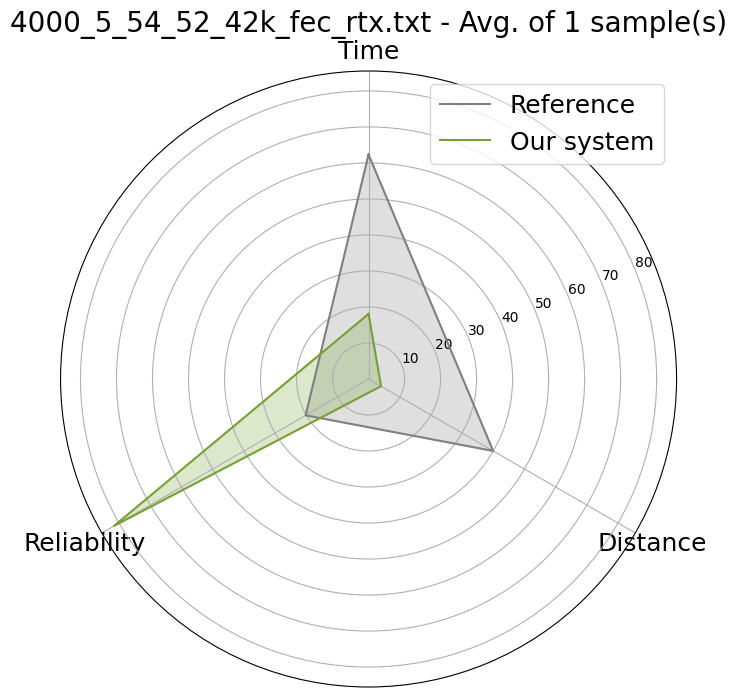

seq: 61, payload[0]: 2, sequence: 0010000100111110, Data: 12, sample_pos: 2, errors: 4
seq: 135, payload[0]: 2, sequence: 0010001011001110, Data: 0, sample_pos: 2, errors: 2
seq: 686, payload[0]: 0, sequence: 0011001101001101, Data: 1, sample_pos: 0, errors: 1
seq: 999, payload[0]: 2, sequence: 0010011011101111, Data: 6, sample_pos: 2, errors: 1
seq: 1052, payload[0]: 0, sequence: 0010001100110011, Data: 1, sample_pos: 0, errors: 2
seq: 1073, payload[0]: 2, sequence: 0010011010100101, Data: 3, sample_pos: 2, errors: 2
seq: 1112, payload[0]: 0, sequence: 0011000000111000, Data: 1, sample_pos: 0, errors: 1
seq: 1176, payload[0]: 2, sequence: 0010110101100111, Data: 2, sample_pos: 2, errors: 1
seq: 1239, payload[0]: 2, sequence: 0001100111010111, Data: 6, sample_pos: 2, errors: 3
seq: 1256, payload[0]: 2, sequence: 0010010010001000, Data: 2, sample_pos: 2, errors: 2
seq: 1304, payload[0]: 2, sequence: 0001010101000011, Data: 15, sample_pos: 2, errors: 3
seq: 1324, payload[0]: 1, sequence:

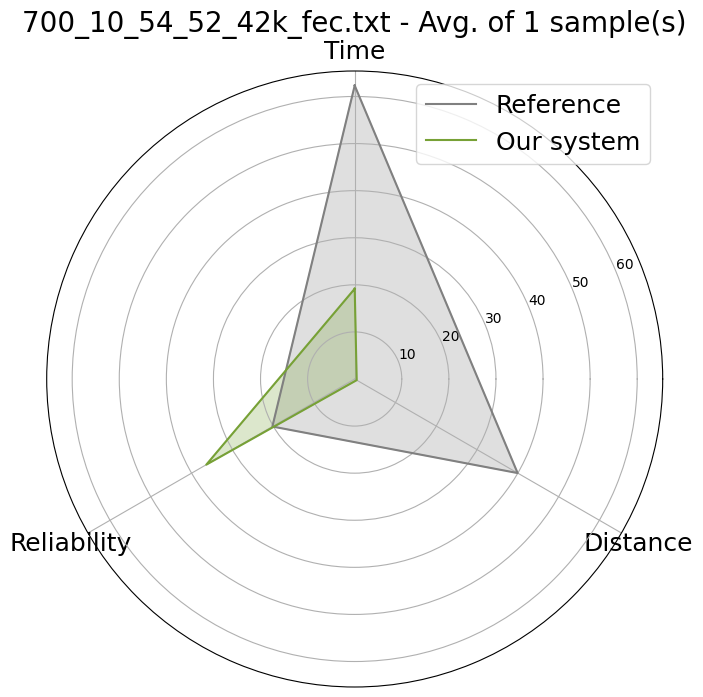

seq: 427, payload[0]: 2, sequence: 0010101010001001, Data: 15, sample_pos: 2, errors: 3
seq: 658, payload[0]: 3, sequence: 0001101010000000, Data: 2, sample_pos: 3, errors: 1
seq: 1266, payload[0]: 0, sequence: 0001110101010101, Data: 2, sample_pos: 0, errors: 2
seq: 1629, payload[0]: 2, sequence: 0010010010001110, Data: 10, sample_pos: 2, errors: 1
seq: 1665, payload[0]: 2, sequence: 0001001101110000, Data: 1, sample_pos: 2, errors: 2
seq: 1931, payload[0]: 2, sequence: 0010111100000000, Data: 15, sample_pos: 2, errors: 4
seq: 1967, payload[0]: 2, sequence: 0010010011000100, Data: 9, sample_pos: 2, errors: 2
seq: 1974, payload[0]: 0, sequence: 0010100101001111, Data: 1, sample_pos: 0, errors: 2
seq: 1990, payload[0]: 0, sequence: 0010000010010100, Data: 1, sample_pos: 0, errors: 2
seq: 2649, payload[0]: 2, sequence: 0010010100111111, Data: 14, sample_pos: 2, errors: 3
seq: 3337, payload[0]: 2, sequence: 0001010100001110, Data: 1, sample_pos: 2, errors: 1
seq: 3357, payload[0]: 2, sequ

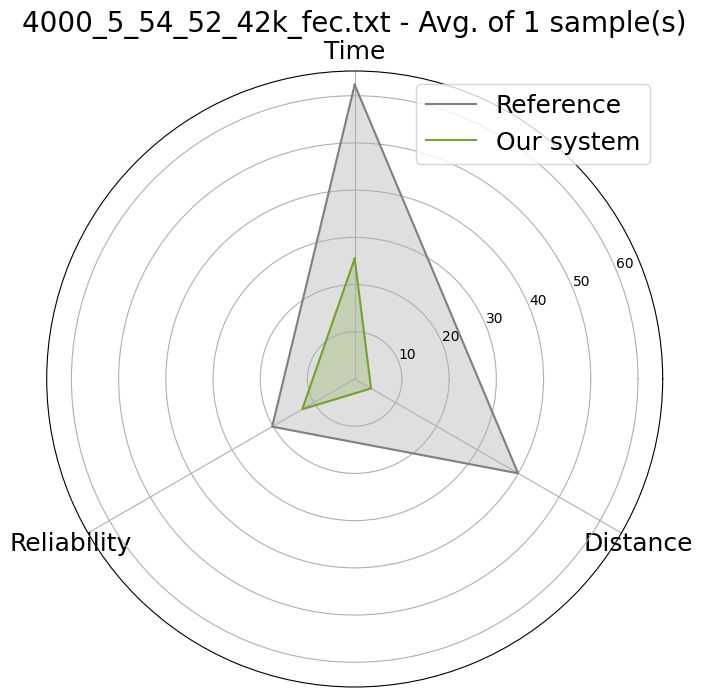

seq: 62, payload[0]: 0, sequence: 0010101011110111, Data: 1, sample_pos: 0, errors: 2
seq: 84, payload[0]: 0, sequence: 0010010000101000, Data: 1, sample_pos: 0, errors: 2
seq: 111, payload[0]: 2, sequence: 0001001110100010, Data: 9, sample_pos: 2, errors: 2
seq: 395, payload[0]: 2, sequence: 0010011011010001, Data: 15, sample_pos: 2, errors: 1
seq: 411, payload[0]: 2, sequence: 0001111010111000, Data: 1, sample_pos: 2, errors: 2
seq: 419, payload[0]: 2, sequence: 0010011001000100, Data: 8, sample_pos: 2, errors: 2
seq: 429, payload[0]: 2, sequence: 0010000001010101, Data: 7, sample_pos: 2, errors: 1
seq: 431, payload[0]: 2, sequence: 0001010010010000, Data: 8, sample_pos: 2, errors: 1
seq: 703, payload[0]: 2, sequence: 0001011110010101, Data: 13, sample_pos: 2, errors: 1
seq: 749, payload[0]: 2, sequence: 0010010001001110, Data: 11, sample_pos: 2, errors: 4
seq: 825, payload[0]: 2, sequence: 0001111100101001, Data: 13, sample_pos: 2, errors: 4
seq: 1049, payload[0]: 2, sequence: 00010

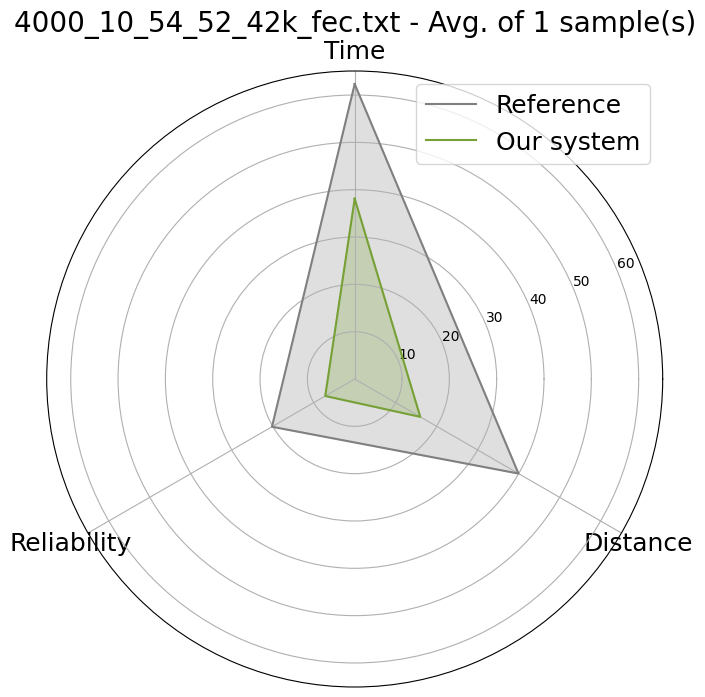

/Users/fadde/Projects/wcnes-project2023/stats/functions.py:247: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  seqs = df.merge(df_rtx, how="outer", sort=True, on="seq")["seq"]


seq: 156, payload[0]: 0, sequence: 0001001100101000, Data: 2, sample_pos: 0, errors: 2
seq: 156, payload[0]: 0, sequence: 0001001100101000, Data: 2, sample_pos: 0, errors: 2
seq: 161, payload[0]: 1, sequence: 0010101110000111, Data: 5, sample_pos: 1, errors: 3
seq: 161, payload[0]: 1, sequence: 0010101110000111, Data: 5, sample_pos: 1, errors: 3
seq: 472, payload[0]: 0, sequence: 0001011101000011, Data: 2, sample_pos: 0, errors: 2
seq: 472, payload[0]: 0, sequence: 0001011101000011, Data: 2, sample_pos: 0, errors: 2
seq: 1001, payload[0]: 1, sequence: 0001011001001110, Data: 15, sample_pos: 1, errors: 2
seq: 1001, payload[0]: 1, sequence: 0001011001001110, Data: 15, sample_pos: 1, errors: 2
seq: 1011, payload[0]: 3, sequence: 0010101000111010, Data: 4, sample_pos: 3, errors: 3
seq: 1011, payload[0]: 3, sequence: 0010101000111010, Data: 4, sample_pos: 3, errors: 3
seq: 1021, payload[0]: 1, sequence: 0001100101101001, Data: 8, sample_pos: 1, errors: 1
seq: 1021, payload[0]: 1, sequence: 

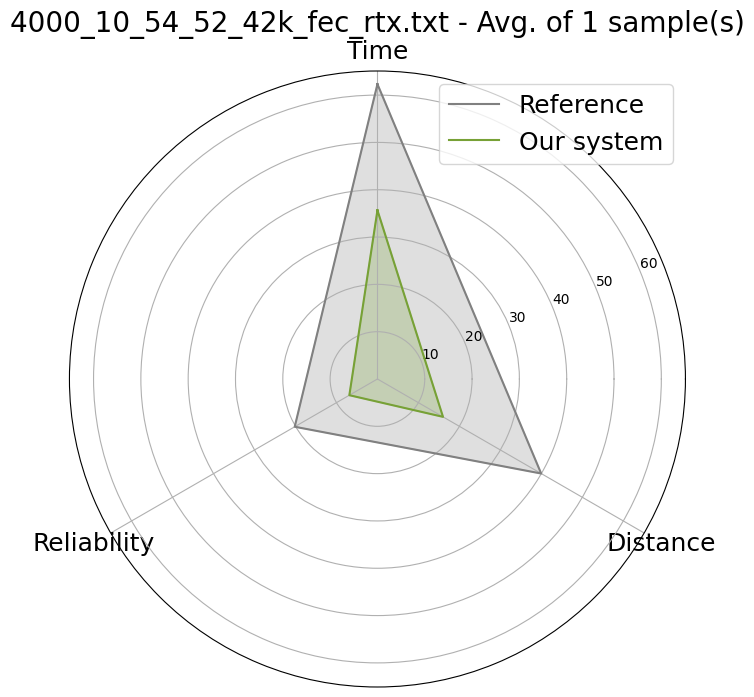

                            file    d2  d1   a   b   baud  delta_fsk file_delay_s bit_reliability dis_metric        etx  misses    avg_rssi    ecc   fec  retransmission  samples  error
4  4000_10_54_52_42k_fec_rtx.txt  4000  10  54  52  42000   44.51567       35.664        6.853202       16.0   6.842656  1153.0 -109.005469  False  True            True        1  False
3      4000_10_54_52_42k_fec.txt  4000  10  54  52  42000   44.51567       38.093        7.188601       16.0  12.199609    14.0 -108.321094  False  True           False        1  False
2       4000_5_54_52_42k_fec.txt  4000   5  54  52  42000   44.51567       25.516       12.835244        4.0   7.224609     5.0 -106.293359  False  True           False        1  False
1       700_10_54_52_42k_fec.txt   700  10  54  52  42000   44.51567        19.17       36.397865       0.49   2.671875     3.0  -99.157813  False  True           False        1  False
0   4000_5_54_52_42k_fec_rtx.txt  4000   5  54  52  42000   44.51567       

In [2]:
import os
import glob
import traceback
from io import StringIO
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file
from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

clock = 125
logdir = f"./logs/{EXPERIMENT}"
experiments_data = []

print(f"Reading experiment folder '{logdir}'...")
for idx, path in enumerate(glob.glob(f"{logdir}/*")):
    log_paths = []
    # We have multiple log files for this configuration and we want to 
    # read them all and get the average. 
    if os.path.isdir(path):
        log_paths = glob.glob(f"{path}/*.txt")
    elif path.endswith(".txt"):
        log_paths.append(path)

    if len(log_paths) == 0:
        continue

    filename = os.path.basename(path)
    params = filename.removesuffix(".txt").split("_")

    use_fec = params[5].lower() == "fec" if len(params) >= 6 else False
    use_retransmission = False
    if len(params) > 6 and use_fec:
        use_retransmission = params[6].lower() == "rtx"

    dfs = [readfile(f, USE_RETRANSMISSION=use_retransmission) for f in log_paths]        

    experiments_data.append({
        "file": filename,
        "d2":int(params[0]), # tag to receiver (cm)
        "d1":int(params[1]), # carrier to tag (cm)
        "a": int(params[2]),
        "b": int(params[3]),
        "baud": int(params[4].replace('k', '000')),
        "delta_fsk": ((clock/int(params[3]) - clock/int(params[2])) * 1000)/2, # khz
        "file_delay_s": None,
        "bit_reliability": None,
        "dis_metric": None,
        "etx": None,
        "misses": None,
        "avg_rssi": None,
        "ecc": params[5].lower() == "ecc" if len(params) >= 6 else False,
        "fec": use_fec,
        "retransmission": use_retransmission, 
        "samples": len(dfs),
        "error": False,
        "dfs": dfs,
    })

def avg(lst):
    if len(lst) == 0:
        return 0
    return sum(lst) / len(lst)

def analyze():
    errors = []
    experiments = pd.DataFrame()

    # codes_hex = [format(int("".join([str(bit) for bit in code]), base=2), "04X") for code in walsh_codes]
    # print(codes_hex)
    # print(walsh_codes)

    for idx, data in enumerate(experiments_data):
        etx_lst = []
        misses_lst = []
        file_delay_s_lst = []
        bit_reliability_lst = []
        dis_metric_lst = []
        rssi_lst = []
        experiment_error = False
        use_ecc = data["ecc"]
        use_fec = data["fec"]

        for df in data["dfs"]:
            try:
                PAYLOADSIZE = 14
                NUM_16RND = int((PAYLOADSIZE-2) // 2) # how many 16 bits random number included in each frame
                if use_ecc:
                    PAYLOADSIZE = 12*3+2
                    NUM_16RND = int(((PAYLOADSIZE-2)/3) // 2) # how many 16 bits random number included in each frame
                elif use_fec:
                    # If rtx is enabled, the byte will be removed automatically
                    # in readfile function (in function.py)
                    PAYLOADSIZE = 5
                    # 4 packets needed to get a full sample, but we index by single 16-bit samples.
                    NUM_16RND = 1
                # if PAYLOADSIZE % 2 != 0:
                #     print("Alarm! the payload size is not even.")

                MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

                payload_lens = set()
                expected_payload_len = (PAYLOADSIZE*3)-1
                for x in df.payload:
                    payload_lens.add(len(x))

                # delete the corrupted packets
                df = df[df.payload.apply(lambda x: len(x)==expected_payload_len)]
                df.reset_index(inplace=True)

                if len(df) == 0:
                    raise Exception(f"All packets are corrupt! Expected payload length of {expected_payload_len}, but got {payload_lens}")

                # replace the resettable seq number to unresettable, for the purpose of reliability calculation
                (test, test_rtx) = replace_seq(df.copy(), MAX_SEQ=256)
                test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)
                test_rtx.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

                file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
                file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000

                ber, error, etx, misses = compute_ber(test, test_rtx, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ, USE_ECC=use_ecc, USE_FEC=use_fec)
                bit_reliability = (1 - ber) * 100
                dis_carrier_tag = data["d1"] / 100 # cm -> m
                dis_tag_rx = data["d2"] / 100 # cm -> m
                dis_metric = dis_carrier_tag**2 * dis_tag_rx**2
                rssi = sum([x for x in df['rssi']])/len(df)

                etx_lst.append(etx)
                misses_lst.append(misses)
                file_delay_s_lst.append(file_delay_s)
                bit_reliability_lst.append(bit_reliability)
                dis_metric_lst.append(dis_metric)
                rssi_lst.append(rssi)
            except Exception as e:
                experiment_error = True
                errors.append((data["file"], "".join(traceback.format_exception(type(e), e, e.__traceback__))))

        avg_etx = avg(etx_lst)
        avg_misses = avg(misses_lst)
        avg_file_delay_s = avg(file_delay_s_lst)
        avg_bit_reliability = avg(bit_reliability_lst)
        avg_dis_metric = avg(dis_metric_lst)
        avg_rssi = avg(rssi_lst)

        del data["dfs"] # do not save log file dataframes to CSV
        experiments = pd.concat([pd.DataFrame(data, index=[idx]), experiments])
        experiments.loc[idx, "etx"] = avg_etx
        experiments.loc[idx, "misses"] = avg_misses
        experiments.loc[idx, "file_delay_s"] = avg_file_delay_s
        experiments.loc[idx, "bit_reliability"] = avg_bit_reliability
        experiments.loc[idx, "dis_metric"] = avg_dis_metric
        experiments.loc[idx, "avg_rssi"] = avg_rssi
        experiments.loc[idx, "error"] = experiment_error

        if not experiment_error:
            metrics = [avg_file_delay_s, avg_bit_reliability, avg_dis_metric]
            radar_plot(metrics, title=f"{data['file']} - Avg. of {data['samples']} sample(s)")

    if len(errors) > 0:
        print(f"{len(errors)} out of {len(experiments)} failed:")
        for (file, error) in errors:
            print(f"{file}:\n{error}")
        print("")

    print(experiments.to_string())

    filepath = Path(f"./results/{EXPERIMENT}.csv")  
    print(f"Saving experiment data to {str(filepath)}...")
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    experiments.to_csv(filepath, index=False)
    print("Successfully saved.")

if len(experiments_data) > 0:
    analyze()
else:
    print(f"No log files found in '{EXPERIMENT}'.")